In [1]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

dfs = pd.read_csv("Facebook_PlayStore 500 PlayStore english reviews sentiment.csv", header=0, parse_dates=[0], index_col=0)

In [2]:
def preprocess_comment(comment):
    # Tokenization
    tokens = nltk.word_tokenize(comment)

    # Remove URL/HTTP
    tokens = [re.sub(r'http\S+|www.\S+', '', token) for token in tokens]

    # Remove hashtags
    tokens = [token for token in tokens if not token.startswith('#')]

    # Remove usernames/user mentions
    tokens = [token for token in tokens if not token.startswith('@')]

    # Menghilangkan emotikon
    tokens = [re.sub(r'[^\w\s\d]', '', token) for token in tokens]

    # Remove symbols and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords]

    # Join tokens back to a single string
    preprocessed_comment = ' '.join(tokens)

    return preprocessed_comment

In [8]:
# dfs['sentiment'] = dfs['sentiment'].replace(0, 2)
# dfs['sentiment'] = dfs['sentiment'].replace(1, 0)
dfs['sentiment'] = dfs['sentiment'].replace(-1, 2)

In [4]:
sentiment_counts = np.bincount(dfs['sentiment'].tolist())

# Print the counts
for sentiment_label, count in enumerate(sentiment_counts):
    print(f"Sentiment {sentiment_label}: {count} occurrences")

Sentiment 0: 186 occurrences
Sentiment 1: 231 occurrences
Sentiment 2: 83 occurrences


In [3]:
dfs['content'] = dfs['content'].apply(preprocess_comment)

In [4]:
dfs

,content,sentiment
0,good app,1
1,hate answering questions,-1
2,useful app app change lifestyle improve langua...,1
3,thanks time today,1
4,good face book,1
...,...,...
495,goodappp,1
496,free facebook,-1
497,id disable reason,-1
498,update app use facebook mobile slide picture ...,0


In [53]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfs, test_size=0.2, random_state=42)

In [6]:
train.to_csv('facebook_playstore_train.csv')

In [10]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [11]:
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [12]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'content'
LABEL_COLUMN = 'sentiment'

In [25]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


     26/Unknown - 3464s 129s/step - loss: 0.8735 - accuracy: 0.6488

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


26/26 [==============================] - 3588s 134s/step - loss: 0.8735 - accuracy: 0.6488 - val_loss: 0.6479 - val_accuracy: 0.7400
Epoch 2/5
26/26 [==============================] - 3805s 147s/step - loss: 0.3605 - accuracy: 0.8825 - val_loss: 0.6186 - val_accuracy: 0.7900
Epoch 3/5
26/26 [==============================] - 2999s 115s/step - loss: 0.1352 - accuracy: 0.9650 - val_loss: 0.6708 - val_accuracy: 0.8000
Epoch 4/5
26/26 [==============================] - 3330s 128s/step - loss: 0.0567 - accuracy: 0.9862 - val_loss: 0.7630 - val_accuracy: 0.8000
Epoch 5/5
26/26 [==============================] - 2031s 78s/step - loss: 0.0150 - accuracy: 0.9975 - val_loss: 0.8488 - val_accuracy: 0.8100


In [13]:
# Save the BERT main layer
model.save_pretrained('facebook_playstore_model')

In [14]:
model = TFBertForSequenceClassification.from_pretrained('facebook_playstore_model')

Some layers from the model checkpoint at facebook_playstore_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at facebook_playstore_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [31]:
# Perform predictions on the evaluation dataset
# predictions = model.predict(validation_data)
predictions_train = model.predict(train_data)

13/13 [==============================] - 196s 15s/step


In [12]:
# Perform predictions on the evaluation dataset
predictions = model.predict(validation_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


4/4 [==============================] - 71s 14s/step


In [32]:
# Obtain the predicted labels
predicted_labels = tf.argmax(predictions.logits, axis=1)
predicted_labels_train = tf.argmax(predictions_train.logits, axis=1)

In [34]:
train['hasil_prediksi'] = predicted_labels_train
test['hasil_prediksi'] = predicted_labelsa

In [50]:
combined_df = pd.concat([train, test])

In [39]:
# List of positive comments (hasil_prediksi == 1)
list_positive_comments = combined_df[combined_df["hasil_prediksi"] == 1]

# List of negative comments (hasil_prediksi == 2)
list_negative_comments = combined_df[combined_df["hasil_prediksi"] == 2]

# List of neutral comments (hasil_prediksi == 0)
list_neutral_comments = combined_df[combined_df["hasil_prediksi"] == 0]

In [40]:
def word_cloud(dfs_reviews,sentiment):
    reviews = dfs_reviews.iloc[:,0]
    all_reviews = ' '.join(reviews.astype(str).tolist())
    
    # NLTK tokenization
    words = word_tokenize(all_reviews)

    # Remove symbols and emoticons
    filtered_words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Remove stopwords
    nltk.download('stopwords')
    stopwords_en = set(stopwords.words('english'))
    filtered_words = [word for word in filtered_words if word.lower() not in stopwords_en]

#     manual_sw = ["facebook","app"]
#     filtered_words = [word for word in filtered_words if word.lower() not in manual_sw]
    filtered_reviews2 = ' '.join(filtered_words)

    # Generate the word cloud with additional parameters
    wordcloud_rsw = WordCloud(
        width=2143,
        height=2143,
        background_color='black',
        color_func=colors,
        mask=masking,
        contour_color='blue',
        contour_width=1,
        font_path='KlavikaRegular-TF.otf',
        max_words=100,
        max_font_size=500
    ).generate(filtered_reviews2)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud_rsw, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Facebook {sentiment} Reviews', fontsize=50, color='black')
    plt.show()

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import ImageColorGenerator
import numpy as np
from PIL import Image

import string
import re

In [48]:
#Create the mask
masking = np.array(Image.open('Facebook.png'))

#Grab the mask colors
colors = ImageColorGenerator(masking)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


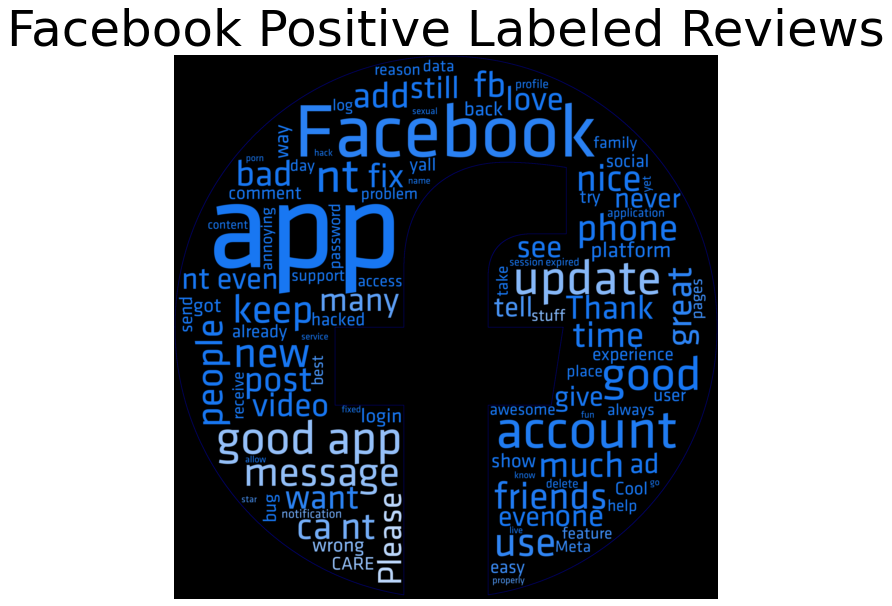

In [49]:
word_cloud(list_positive_comments,sentiment='Positive Labeled')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


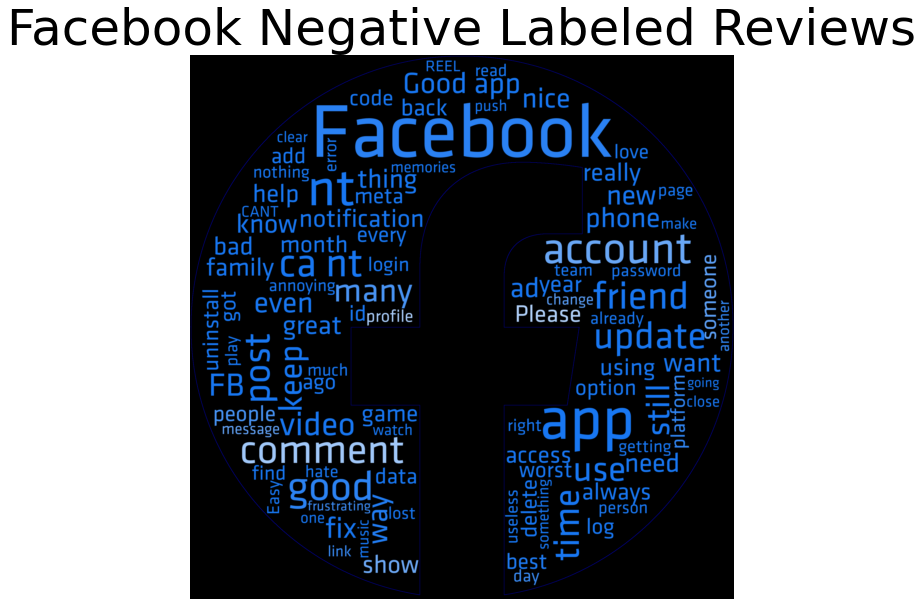

In [51]:
word_cloud(list_negative_comments,sentiment='Negative Labeled')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


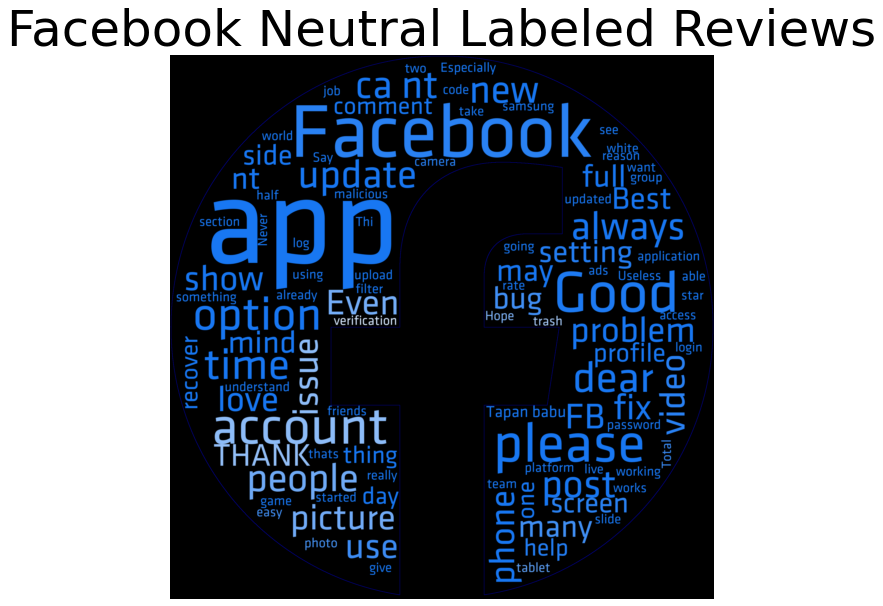

In [52]:
word_cloud(list_neutral_comments,sentiment='Neutral Labeled')

In [18]:
# Obtain the predicted labels
predicted_labels = tf.argmax(predictions.logits, axis=1)

# Obtain the ground truth labels
ground_truth_labels =  test.iloc[:,-1].tolist()

# Create the confusion matrix
confusion_mat = confusion_matrix(ground_truth_labels, predicted_labels)

# Convert the confusion matrix to a pandas DataFrame for better visualization
labels = ['Positive','Neutral','Negative']  # Replace with your actual label names

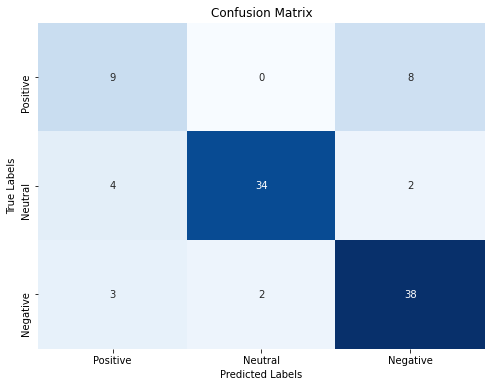

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Generate classification report
target_names = ['neutral', 'positive', 'negative']
classification_rep = classification_report(ground_truth_labels, predicted_labels, target_names=target_names)
print(classification_rep)

Accuracy: 0.81
              precision    recall  f1-score   support

     neutral       0.56      0.53      0.55        17
    positive       0.94      0.85      0.89        40
    negative       0.79      0.88      0.84        43

    accuracy                           0.81       100
   macro avg       0.77      0.75      0.76       100
weighted avg       0.81      0.81      0.81       100

